# Sentiment analysis on Covid-19 tweets with deep learning

Classify 45k tweets on Covid-19 as positive or negative based on the following deep learning models: 

* Simple RNN
* LSTM
* GRU 
* Bidirectional LSTM

The tweets are preprocessed using the following NLP methods before being fed as inputs to the neural network models: 

* Keras embedding layers 
* Pre-trained Spacy word embeddings

In [97]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import string
import joblib

from warnings import filterwarnings
filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from __future__ import absolute_import, division, print_function, unicode_literals

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import collections
from collections import Counter
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

import transformers
from transformers import BertTokenizer, TFBertModel

In [98]:
try:
    import h5py
    print ('import fine')
except ImportError:
    h5py = None

import fine


In [99]:
def preprocessor(text):
    # convert to lowercase, susbstitute non alphanumerical characters with whitespaces
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [100]:
def test_performance(model, X_test): 
    ''' Given a fitted model and a test set, returns optimal hyperparameters, AUC and accuracy '''
    clf_b = model.best_estimator_
    y_pred_proba = clf_b.predict_proba(X_test)
    y_pred = clf_b.predict(X_test)

    # performance metrics
    auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])
    acc = accuracy_score(y_test, y_pred)
    
    return (model.best_params_, auc_res, acc)


# NLP Preprocessing

## Embedding

* Randomly reshuffle data
* Estimate embedding matrix with Keras 
* Initialize Keras embedding layer with pre-trained Spacy word embedding



In [101]:
df = pd.read_csv("./binary_data.csv")
df.shape

(35555, 3)

In [102]:
# reshuffle data
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation

In [103]:
# remove punctuation, non alphanumerical characters and lowercase
df["tweet_clean"] = df['OriginalTweet'].apply(preprocessor)

In [104]:
# load pre-trained word embedding model from spacy
nlp = spacy.load('en_core_web_md') 

# stack embeddings of tweets
emb = np.vstack(df.tweet_clean.apply(lambda x: nlp(x).vector))

savetxt('./embedded_data.csv', emb, delimiter=',')

## Basic preprocessing: 

* Convert to lowercase and split tokens on whitespaces and puncutuation
* Map every word to an integer value
* Set each tweet to an equal length  𝑇  by padding with 0 or slicing 

## Hyperparameters for Keras preprocessor

* num_words: size of the vocabulary based on most frequent words in tweets
* maxlen: sequence length $T$ to ensure that all tweets have the same length 

In [105]:
# find size of vocabulary = number of words that appear more than 1 time 
counts = Counter()
for i, news in enumerate(df['OriginalTweet']):
    text = news.lower() # convert to lowercase
    df.loc[i, "OriginalTweet"] = text
    counts.update(text.split()) # splitting on whitespace

In [106]:
print('Number of unique words:', len(counts))
print('Number of words that appear more than 1 time:', len( [k for k, v in counts.items() if v > 1] ))
print('Number of words that appear more than 10 times:', len( [k for k, v in counts.items() if v > 10] ))

Number of unique words: 107861
Number of words that appear more than 1 time: 30837
Number of words that appear more than 10 times: 7059


In [107]:
# our vocabulary consists of words that appear more than 10 times 
vocab_size = len( [k for k, v in counts.items() if v > 10] )

In [108]:
# most frequent words that appear more than 5 times
word_counts = sorted(counts, key=counts.get, reverse=True)
word_counts = word_counts[1:vocab_size]
print( word_counts[:20] ) # show first 20 words

['to', 'and', 'of', 'a', 'in', 'for', '#coronavirus', 'is', 'are', 'on', 'i', 'you', 'this', 'at', 'with', 'food', 'prices', 'that', 'we', 'have']


In [109]:
# assign an index to all words in word_counts
word_to_int = {}
for i, word in enumerate(word_counts): 
    word_to_int[word] = i

In [110]:
# create a list with all tweets, where each tweet contains only the indexes of most frequent words
mapped_tweet = []
for tweet in df['OriginalTweet']:
    mapped_tweet.append([word_to_int[word] 
                           for word in tweet.split() 
                           if word in word_to_int.keys()])
    
print( mapped_tweet[:10] )

[[18, 40, 29, 69, 34, 690, 4, 325, 0, 27, 15, 1, 866, 477, 43, 1480, 133, 9, 478, 37, 1926, 58, 8, 954, 44, 16, 2, 817, 1724, 11, 337, 43, 5894, 173, 923, 0, 69, 1, 32, 122, 23, 3327, 28, 12, 496], [104, 2737, 2, 1829, 28, 232, 115, 182, 259, 255, 590, 53, 36, 32, 78, 192, 54, 6, 628, 50, 1087, 1, 260, 16], [295, 44, 13, 33, 22, 24, 209, 29, 170, 214, 245, 10, 67, 61, 169, 33, 503, 2738, 1, 80, 67, 51, 833, 37, 97, 977, 789, 3533, 133, 5054, 1507, 15, 84, 173, 62, 12, 6244, 789, 84, 3, 851, 591, 1577, 6], [14, 1043, 370, 2, 27, 4, 1034, 97, 773, 71, 89, 1, 70, 15, 7, 3004, 188, 121, 4, 22, 130, 274], [5, 117, 58, 1806, 453, 272, 924, 78, 61, 94, 518, 237, 1301, 10, 2450, 806, 2799, 55, 3421, 2, 37, 127, 248, 26, 44, 1624, 1, 978, 331, 2620, 409, 2800, 30, 220, 62, 96, 249, 13, 22, 24, 42], [52, 1399, 0, 119, 29, 96, 2621, 6624, 3422, 774, 145, 394, 691, 1541, 66, 278, 189, 7, 81, 0, 21, 6245, 110, 30, 3423, 1400, 308, 238, 32, 5564, 394, 197, 625, 30, 74, 17, 32, 76, 0, 1079, 0, 15, 34

In [111]:
# set length of each tweet equal to median length of mapped_tweet
sequence_length = np.median([len(tweet) for tweet in mapped_tweet])
sequence_length

27.0

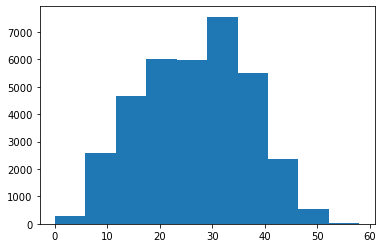

In [112]:
rev_lengths = np.array([len(tweet) for tweet in mapped_tweet])
plt.hist(rev_lengths)
plt.show()

In [113]:
# map words to integers with preprocessing using keras tokenizer
tokenizer = Tokenizer(num_words=vocab_size, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # filters out all punctuation
                      lower=True, # convert to lowercase
                      split=' ') # split on whitespaces

tokenizer.fit_on_texts(df['OriginalTweet'])
list_tokenized = tokenizer.texts_to_sequences(df['OriginalTweet'])

print( list_tokenized[:10] )

[[28, 49, 37, 75, 43, 709, 10, 335, 2, 13, 12, 21, 4, 815, 409, 53, 1498, 146, 18, 283, 47, 919, 66, 16, 1037, 44, 23, 6, 794, 186, 17, 336, 53, 650, 201, 911, 2, 75, 4, 40, 130, 34, 3308, 36, 20, 96], [113, 2617, 6, 1481, 36, 241, 109, 1, 202, 282, 213, 613, 60, 45, 40, 79, 176, 63, 11, 2002, 640, 59, 897, 6781, 4, 270, 23, 8, 5, 7], [1, 274, 44, 22, 41, 32, 25, 236, 37, 1, 175, 222, 152, 19, 80, 70, 187, 41, 429, 316, 4, 87, 80, 55, 592, 47, 103, 111, 839, 3394, 146, 575, 1, 1461, 21, 94, 5688, 201, 69, 20, 37, 109, 1158, 839, 94, 9, 854, 568, 106, 11], [24, 1074, 368, 6, 13, 12, 10, 976, 103, 111, 81, 77, 4, 62, 21, 15, 2831, 181, 1, 115, 10, 32, 127, 307, 1, 8, 5, 7], [3776, 14, 125, 66, 1859, 492, 230, 986, 79, 70, 101, 503, 249, 58, 19, 2470, 785, 2471, 64, 1, 2891, 6, 4946, 47, 141, 265, 33, 44, 57, 4, 995, 366, 6345, 1860, 330, 2832, 38, 224, 69, 104, 260, 6003, 22, 1, 32, 25, 337, 13, 12], [58, 1111, 2, 129, 37, 104, 485, 1901, 3151, 729, 131, 436, 707, 1132, 1, 291, 194, 15, 

In [114]:
# dictionary of words with indices
word_index = tokenizer.word_index

In [115]:
# convert all tweets to same length by padding with 0 or slicing
sequence_length = 35 # select 35 as max length based on distribution of mapped tweets
sequences = pad_sequences(list_tokenized, maxlen= sequence_length)
print(sequences)

[[ 21   4 815 ...  36  20  96]
 [  0   0   0 ...   8   5   7]
 [ 70 187  41 ... 568 106  11]
 ...
 [  0   0   0 ...  10 147 849]
 [  0   0   9 ...   9 692  12]
 [  0   0   0 ...  34  65 685]]


In [116]:
# convert sentiment to real valued
le = LabelEncoder()
le.fit(df['Sentiment'])
df['target_encoded'] = le.transform(df['Sentiment'])

In [117]:
df_processed = pd.concat([df[['Sentiment', "target_encoded", "tweet_clean"]], pd.DataFrame(sequences)], axis=1)
df_processed.head()

,Sentiment,target_encoded,tweet_clean,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,34
0,Negative,0,we can all do our bit in response to covid 19 ...,21,4,815,409,53,1498,146,...,2,75,4,40,130,34,3308,36,20,96
1,Positive,1,after loads of emails from companies over the ...,0,0,0,0,0,113,2617,...,640,59,897,6781,4,270,23,8,5,7
2,Positive,1,the line up at my grocery store went all the w...,70,187,41,429,316,4,87,...,37,109,1158,839,94,9,854,568,106,11
3,Positive,1,with four cases of covid 19 in greene county t...,0,0,0,0,0,0,0,...,1,115,10,32,127,307,1,8,5,7
4,Positive,1,btw for those who claim wearing mask doesn t h...,19,2470,785,2471,64,1,2891,...,104,260,6003,22,1,32,25,337,13,12


In [118]:
# save data
df_processed.to_csv("./data_deeplearning.csv", index = False, encoding = "utf-8")

# Recurrent neural networks (RNN)

* The machine learning approach to text analysis relies heavily on text preprocessing
* RNNs are used to implement most of the NLP preprocessing as well as classification tasks

A RNN is a neural network architecture suited to deal with sequential data. In contrast to feedforward neural networks, they allow for cycles in their architecture in order to take into account the activations of the previous step. Hence, they have some form of "memory" of the structure of the training data. 

For input data $x = (x_1, ..., x_T)$, the RNN architecture computes a sequence of outputs $(z_1^1, ..., z_T^1)$, where each output isa function of the feature information at the same timestep and the output information from the previous timestep, i.e. $z_{j+1}^1 = z^1(x_{j+1}, z_j^1), \forall j = 1, ..., T-1$

The most commonly used gradient-based learning algorithm to
update RNN parameters is Backpropagation Through Time (BPTT), which is applied to
the unfolded network in order to compute the gradients at each timestep. However, the recurisve computation of these gradients often lead to exploding or vanishing gradients. Gated RNN architectures, such as Long Short-Term Memory (LSTM) or Gated Recurrent Units (GRU) solve this problem.

--------------------------------------------------------------------------------------------------

The models are trained on the following NLP preprocessed data: 

* **Word embeddings**: word embeddings are trained using Keras embedding layer, which converts each word into fixed length, dense, real-valued vector of defined size.
    Parameters:

    * input_dim : Size of the vocabulary (equal to the size of the embedding matrix)
    * output_dim : Length of the vector for each word
    * input_length : Maximum length of a sequence

* **Pre-trained Spacy word embeddings**: used as weights in Keras embedding layer (transfer learning). Additional parameters:

    * weights: Embedding matrix computed from pretrained Spacy embeddings
    * trainable = False: do not retrain word embeddings

In [273]:
df = pd.read_csv("./data_deeplearning.csv")

In [274]:
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

28444 7111


In [275]:
remove = ['Sentiment', "target_encoded", "tweet_clean"]

# split dataset
X_train = np.array(df.head(train_size).drop(remove, axis=1)) # replace with n_train
y_train = df.head(train_size).target_encoded.values

X_test = np.array(df.tail(test_size).drop(remove, axis=1)) # replace with n_test
y_test = df.tail(test_size).target_encoded.values

print('Training data X, y:', X_train.shape, y_train.shape)
print('Testing data X, y:', X_test.shape, y_test.shape)

Training data X, y: (28444, 35) (28444,)
Testing data X, y: (7111, 35) (7111,)


In [122]:
# load embedding matrix
emb = loadtxt('.\embedded_data.csv', delimiter=',')
emb

array([[-0.18039519,  0.15100001, -0.08651307, ..., -0.11266083,
         0.09260193,  0.13436501],
       [-0.11535835,  0.17786935, -0.15773802, ...,  0.01470347,
         0.03781296,  0.07737374],
       [-0.04265941,  0.07776086, -0.13678007, ..., -0.11700895,
         0.05279943,  0.07373761],
       ...,
       [-0.11585855,  0.16935857,  0.05481516, ...,  0.04117206,
         0.01730863,  0.08014087],
       [-0.13310415,  0.19906546, -0.00468867, ..., -0.10085647,
        -0.00446249,  0.05838124],
       [-0.20245384,  0.13679789, -0.13991286, ..., -0.10382908,
         0.0231565 ,  0.12365782]])

Simple RNN
---------------------------------------------------------------------------------------------



In [123]:
# paramerers, based on results from preprocessing
emb_length = 300
max_length = 58 # length of longest sequence
sequence_length = 35 

### Keras embedding layer

In [124]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))

model.add(layers.SimpleRNN(sequence_length, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-2,
    patience=3,
    verbose=1,
    restore_best_weights=True)]

In [126]:
# train the model
history = model.fit(X_train, 
         y_train, 
         validation_data = (X_test, y_test),
         epochs=7, 
         batch_size=32,
         callbacks=callbacks,
         verbose=1)

model.save("SimpleRNN_1")

Epoch 1/7
889/889 [==============================] - 98s 109ms/step - loss: 0.7058 - accuracy: 0.5295 - val_loss: 0.6827 - val_accuracy: 0.5611
Epoch 2/7
889/889 [==============================] - 98s 110ms/step - loss: 0.6631 - accuracy: 0.5982 - val_loss: 0.6768 - val_accuracy: 0.5761
Epoch 3/7
889/889 [==============================] - 94s 105ms/step - loss: 0.5541 - accuracy: 0.7273 - val_loss: 0.5370 - val_accuracy: 0.7554
Epoch 4/7
889/889 [==============================] - 96s 108ms/step - loss: 0.4398 - accuracy: 0.8212 - val_loss: 0.4896 - val_accuracy: 0.7819
Epoch 5/7
889/889 [==============================] - 99s 111ms/step - loss: 0.3747 - accuracy: 0.8565 - val_loss: 0.4890 - val_accuracy: 0.7902
Epoch 6/7
889/889 [==============================] - 95s 107ms/step - loss: 0.3158 - accuracy: 0.8845 - val_loss: 0.4625 - val_accuracy: 0.8075
Epoch 7/7
889/889 [==============================] - 95s 107ms/step - loss: 0.2765 - accuracy: 0.9032 - val_loss: 0.4824 - val_accuracy:

INFO:tensorflow:Assets written to: SimpleRNN_1\assets


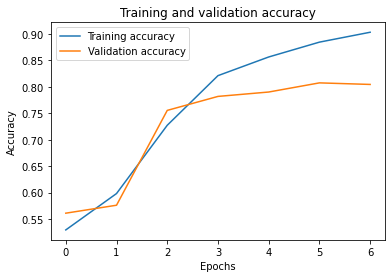

In [127]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

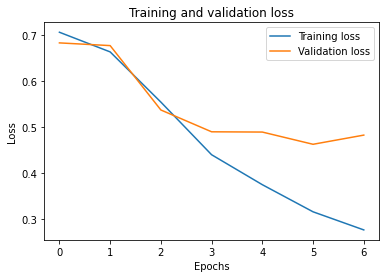

In [128]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained Spacy embedding

In [174]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))

model.add(layers.SimpleRNN(sequence_length, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [175]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [176]:
# train the model
history = model.fit(X_train, 
         y_train, 
         validation_data = (X_test, y_test),
         epochs=20, 
         batch_size=32,
         callbacks=callbacks,
         verbose=1)

model.save("SimpleRNN_2")

Epoch 1/20
889/889 [==============================] - 8s 8ms/step - loss: 0.7026 - accuracy: 0.5181 - val_loss: 0.6899 - val_accuracy: 0.5349
Epoch 2/20
889/889 [==============================] - 7s 8ms/step - loss: 0.6919 - accuracy: 0.5323 - val_loss: 0.6897 - val_accuracy: 0.5366
Epoch 3/20
889/889 [==============================] - 7s 8ms/step - loss: 0.6909 - accuracy: 0.5303 - val_loss: 0.6899 - val_accuracy: 0.5337
Epoch 4/20
889/889 [==============================] - 7s 8ms/step - loss: 0.6898 - accuracy: 0.5337 - val_loss: 0.6897 - val_accuracy: 0.5354
Epoch 5/20
889/889 [==============================] - 7s 8ms/step - loss: 0.6892 - accuracy: 0.5374 - val_loss: 0.6897 - val_accuracy: 0.5358
Epoch 6/20
889/889 [==============================] - 7s 8ms/step - loss: 0.6891 - accuracy: 0.5419 - val_loss: 0.6894 - val_accuracy: 0.5365
Epoch 7/20
889/889 [==============================] - 7s 8ms/step - loss: 0.6887 - accuracy: 0.5439 - val_loss: 0.6894 - val_accuracy: 0.5369
Restor

INFO:tensorflow:Assets written to: SimpleRNN_2\assets


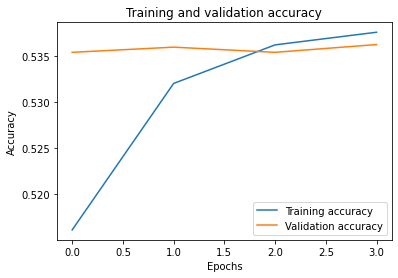

In [138]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

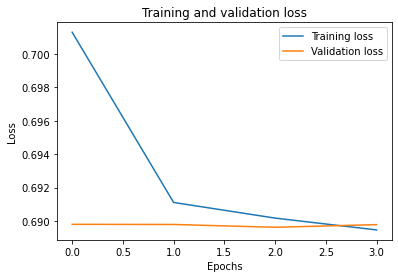

In [139]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## LSTM

LSTM units replace hidden neurons in RNN architectures by more complex
    memory cells. A memory cell takes three inputs: the input features $x_t$, the neural activations $z_{t-1}^1$ and the cell state $c_{t-1}^1$ from the previous step, and outputs a new cell state $c_t^1$ and neural activations $z_t^1$. Each memory cell consists of three gates that control the flow of information through the cell: 
    
* **Forget Gate**: this gate decides what information should be thrown away or kept. Information from the previous hidden state and information from the current input is passed through the sigmoid function. Values come out between 0 and 1. The closer to 0 means to forget, and the closer to 1 means to keep.
* **Input Gate**: to update the cell state, we have the input gate. First, we pass the previous hidden state and current input into a sigmoid function. That decides which values will be updated by transforming the values to be between 0 and 1. 0 means not important, and 1 means important. 
* **Output gate**: the output gate decides what the next hidden state, which contains information on previous inputs, should be. The hidden state is also used for predictions. First, we pass the previous hidden state and the current input into a sigmoid function. Then we pass the newly modified cell state to the tanh function. We multiply the tanh output with the sigmoid output to decide what information the hidden state should carry. The output is the hidden state. The new cell state and the new hidden is then carried over to the next time step.


### Keras embedding layer

In [142]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))

model.add(layers.LSTM(sequence_length, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [143]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-2,
    patience=3,
    verbose=1,
    restore_best_weights=True)]

In [144]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=7, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("LSTM_1")

Epoch 1/7
889/889 [==============================] - 110s 120ms/step - loss: 0.4625 - accuracy: 0.7797 - val_loss: 0.3542 - val_accuracy: 0.8460
Epoch 2/7
889/889 [==============================] - 108s 122ms/step - loss: 0.2790 - accuracy: 0.8876 - val_loss: 0.3086 - val_accuracy: 0.8658
Epoch 3/7
889/889 [==============================] - 109s 122ms/step - loss: 0.2051 - accuracy: 0.9192 - val_loss: 0.3320 - val_accuracy: 0.8639
Epoch 4/7
889/889 [==============================] - 106s 119ms/step - loss: 0.1601 - accuracy: 0.9378 - val_loss: 0.4025 - val_accuracy: 0.8670
Epoch 5/7
889/889 [==============================] - 107s 120ms/step - loss: 0.1258 - accuracy: 0.9540 - val_loss: 0.4236 - val_accuracy: 0.8644
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping
INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


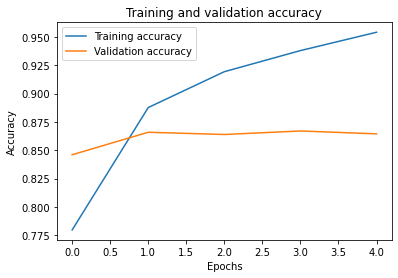

In [145]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

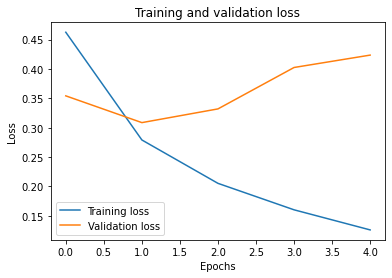

In [146]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained word embeddings

In [192]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))

model.add(layers.LSTM(sequence_length, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [193]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [194]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=30, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("LSTM_2")

Epoch 1/30
889/889 [==============================] - 33s 34ms/step - loss: 0.6919 - accuracy: 0.5313 - val_loss: 0.6882 - val_accuracy: 0.5458
Epoch 2/30
889/889 [==============================] - 29s 33ms/step - loss: 0.6886 - accuracy: 0.5394 - val_loss: 0.6861 - val_accuracy: 0.5427
Epoch 3/30
889/889 [==============================] - 28s 31ms/step - loss: 0.6786 - accuracy: 0.5686 - val_loss: 0.6708 - val_accuracy: 0.5867
Epoch 4/30
889/889 [==============================] - 28s 31ms/step - loss: 0.6650 - accuracy: 0.6000 - val_loss: 0.6545 - val_accuracy: 0.6140
Epoch 5/30
889/889 [==============================] - 28s 31ms/step - loss: 0.6508 - accuracy: 0.6215 - val_loss: 0.6361 - val_accuracy: 0.6334
Epoch 6/30
889/889 [==============================] - 28s 32ms/step - loss: 0.6360 - accuracy: 0.6344 - val_loss: 0.6098 - val_accuracy: 0.6607
Epoch 7/30
889/889 [==============================] - 28s 31ms/step - loss: 0.6229 - accuracy: 0.6476 - val_loss: 0.6030 - val_accuracy:

INFO:tensorflow:Assets written to: LSTM_2\assets


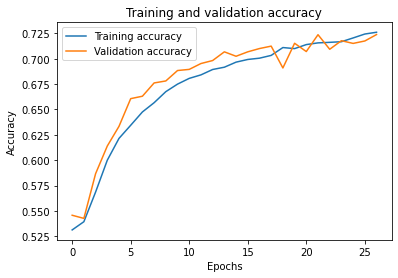

In [195]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

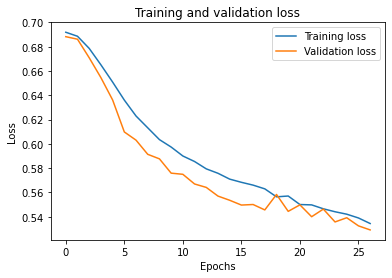

In [196]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

GRU
-------------------------------------------------------------------------------

Uses a similar but less complex memory cell architecture as LSTM, composed by:

* **Update gate**: It determines how much of the past knowledge needs to be passed along into the future. It is analogous to the output gate in an LSTM recurrent unit.

* **Reset gate**:  It determines how much of the past knowledge to forget. It is analogous to the combination of the input Gate and the forget Gate in an LSTM recurrent unit.

* **Current Memory Gate**: It is incorporated into the Reset Gate and is used to introduce some non-linearity into the input and to also make the input zero-mean. It also reduces the effect that previous information has on the current information that is being passed into the future.

### Keras embedding layer

In [233]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))


model.add(layers.SpatialDropout1D(0.3))
model.add(layers.GRU(sequence_length))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [234]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [235]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=10, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("GRU_1")

Epoch 1/10
889/889 [==============================] - 103s 114ms/step - loss: 0.4668 - accuracy: 0.7714 - val_loss: 0.3340 - val_accuracy: 0.8598
Epoch 2/10
889/889 [==============================] - 104s 117ms/step - loss: 0.2685 - accuracy: 0.8944 - val_loss: 0.2996 - val_accuracy: 0.8730
Epoch 3/10
889/889 [==============================] - 108s 122ms/step - loss: 0.1950 - accuracy: 0.9250 - val_loss: 0.3170 - val_accuracy: 0.8681
Epoch 4/10
889/889 [==============================] - 111s 124ms/step - loss: 0.1464 - accuracy: 0.9480 - val_loss: 0.3869 - val_accuracy: 0.8678
Epoch 5/10
889/889 [==============================] - 106s 119ms/step - loss: 0.1065 - accuracy: 0.9623 - val_loss: 0.4393 - val_accuracy: 0.8620
Epoch 6/10
889/889 [==============================] - 107s 120ms/step - loss: 0.0792 - accuracy: 0.9722 - val_loss: 0.5015 - val_accuracy: 0.8540
Epoch 7/10
889/889 [==============================] - 106s 120ms/step - loss: 0.0614 - accuracy: 0.9793 - val_loss: 0.5614 -

INFO:tensorflow:Assets written to: GRU_1\assets


INFO:tensorflow:Assets written to: GRU_1\assets


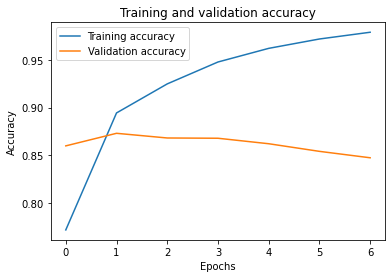

In [236]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

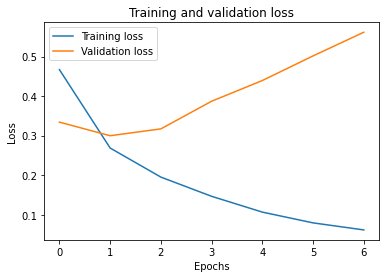

In [237]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained word embeddings

In [238]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))


model.add(layers.SpatialDropout1D(0.3))
model.add(layers.GRU(sequence_length))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [239]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [240]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=30, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("GRU_2")

Epoch 1/30
889/889 [==============================] - 19s 19ms/step - loss: 0.6945 - accuracy: 0.5250 - val_loss: 0.6881 - val_accuracy: 0.5431
Epoch 2/30
889/889 [==============================] - 17s 19ms/step - loss: 0.6880 - accuracy: 0.5423 - val_loss: 0.6842 - val_accuracy: 0.5648
Epoch 3/30
889/889 [==============================] - 16s 18ms/step - loss: 0.6731 - accuracy: 0.5792 - val_loss: 0.6576 - val_accuracy: 0.5954
Epoch 4/30
889/889 [==============================] - 16s 18ms/step - loss: 0.6519 - accuracy: 0.6093 - val_loss: 0.6672 - val_accuracy: 0.5724
Epoch 5/30
889/889 [==============================] - 16s 18ms/step - loss: 0.6310 - accuracy: 0.6346 - val_loss: 0.6100 - val_accuracy: 0.6570
Epoch 6/30
889/889 [==============================] - 17s 19ms/step - loss: 0.6178 - accuracy: 0.6519 - val_loss: 0.6060 - val_accuracy: 0.6525
Epoch 7/30
889/889 [==============================] - 16s 18ms/step - loss: 0.6068 - accuracy: 0.6618 - val_loss: 0.5899 - val_accuracy:

INFO:tensorflow:Assets written to: GRU_2\assets


INFO:tensorflow:Assets written to: GRU_2\assets


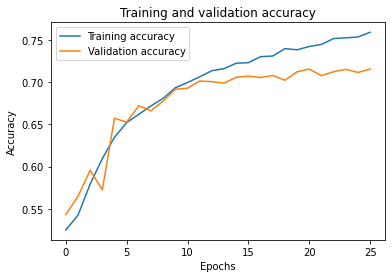

In [241]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

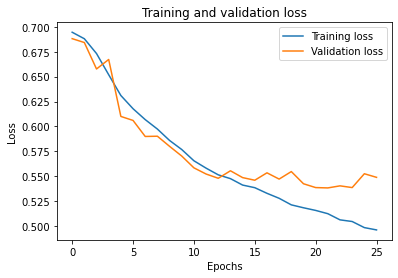

In [242]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Bidirectional RNN

Bidirectional RNN consists of putting two independent RNNs together: one whose input sequence is processed in normal time order, and another which is processed in reverse time order. This way, the network has both backward and forward information about the sequence at every time step.  The outputs of the two RNNs are concatenated at each time step. 

### Keras embedding layer

In [216]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))

model.add(layers.Bidirectional(layers.LSTM(sequence_length, dropout = 0.3, recurrent_dropout = 0.3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [217]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [218]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=10, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("BI_LSTM_1")

Epoch 1/10
889/889 [==============================] - 176s 191ms/step - loss: 0.4611 - accuracy: 0.7772 - val_loss: 0.3314 - val_accuracy: 0.8584
Epoch 2/10
889/889 [==============================] - 162s 183ms/step - loss: 0.2704 - accuracy: 0.8932 - val_loss: 0.3045 - val_accuracy: 0.8710
Epoch 3/10
889/889 [==============================] - 162s 182ms/step - loss: 0.1940 - accuracy: 0.9240 - val_loss: 0.3386 - val_accuracy: 0.8706
Epoch 4/10
889/889 [==============================] - 162s 182ms/step - loss: 0.1397 - accuracy: 0.9476 - val_loss: 0.3388 - val_accuracy: 0.8643
Epoch 5/10
889/889 [==============================] - 167s 188ms/step - loss: 0.1004 - accuracy: 0.9639 - val_loss: 0.4275 - val_accuracy: 0.8585
Epoch 6/10
889/889 [==============================] - 183s 206ms/step - loss: 0.0725 - accuracy: 0.9752 - val_loss: 0.5040 - val_accuracy: 0.8606
Epoch 7/10
889/889 [==============================] - 181s 204ms/step - loss: 0.0538 - accuracy: 0.9817 - val_loss: 0.5830 -

INFO:tensorflow:Assets written to: BI_LSTM_1\assets


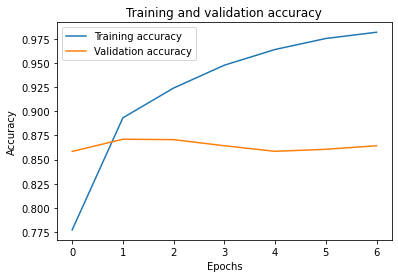

In [219]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

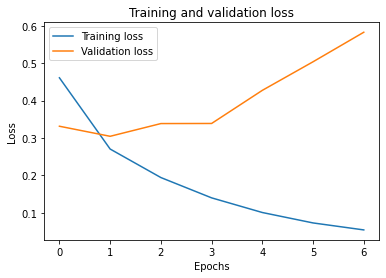

In [220]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained word embeddings

In [221]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))

model.add(layers.Bidirectional(layers.LSTM(sequence_length, dropout = 0.3, recurrent_dropout = 0.3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [222]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [223]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=30, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("BI_LSTM_2")

Epoch 1/30
889/889 [==============================] - 60s 62ms/step - loss: 0.6926 - accuracy: 0.5278 - val_loss: 0.6899 - val_accuracy: 0.5387
Epoch 2/30
889/889 [==============================] - 54s 61ms/step - loss: 0.6887 - accuracy: 0.5416 - val_loss: 0.6886 - val_accuracy: 0.5311
Epoch 3/30
889/889 [==============================] - 56s 63ms/step - loss: 0.6782 - accuracy: 0.5725 - val_loss: 0.6743 - val_accuracy: 0.5708
Epoch 4/30
889/889 [==============================] - 56s 63ms/step - loss: 0.6643 - accuracy: 0.5987 - val_loss: 0.6564 - val_accuracy: 0.6103
Epoch 5/30
889/889 [==============================] - 60s 67ms/step - loss: 0.6485 - accuracy: 0.6205 - val_loss: 0.6327 - val_accuracy: 0.6300
Epoch 6/30
889/889 [==============================] - 59s 67ms/step - loss: 0.6326 - accuracy: 0.6386 - val_loss: 0.6171 - val_accuracy: 0.6557
Epoch 7/30
889/889 [==============================] - 54s 61ms/step - loss: 0.6205 - accuracy: 0.6488 - val_loss: 0.6128 - val_accuracy:

INFO:tensorflow:Assets written to: BI_LSTM_2\assets


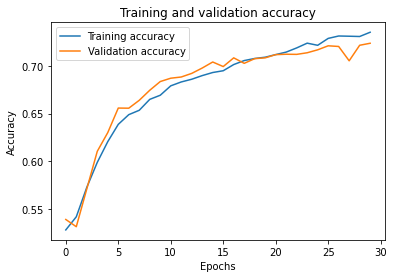

In [224]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

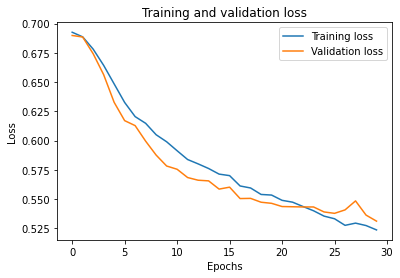

In [225]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Compare model performance

In [276]:
model_names = ["SimpleRNN_1", "SimpleRNN_2", "LSTM_1", "LSTM_2", "GRU_1", "GRU_2"]

acc = dict()
auc_res = dict()
for model in model_names: 
    loaded_model = tf.keras.models.load_model(model)
    results = loaded_model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    y_pred = loaded_model.predict_proba(X_test, batch_size=32)
    acc[model] = results[1]
    auc_res[model] = roc_auc_score(y_test, y_pred[:, 0]) 

<BarContainer object of 6 artists>

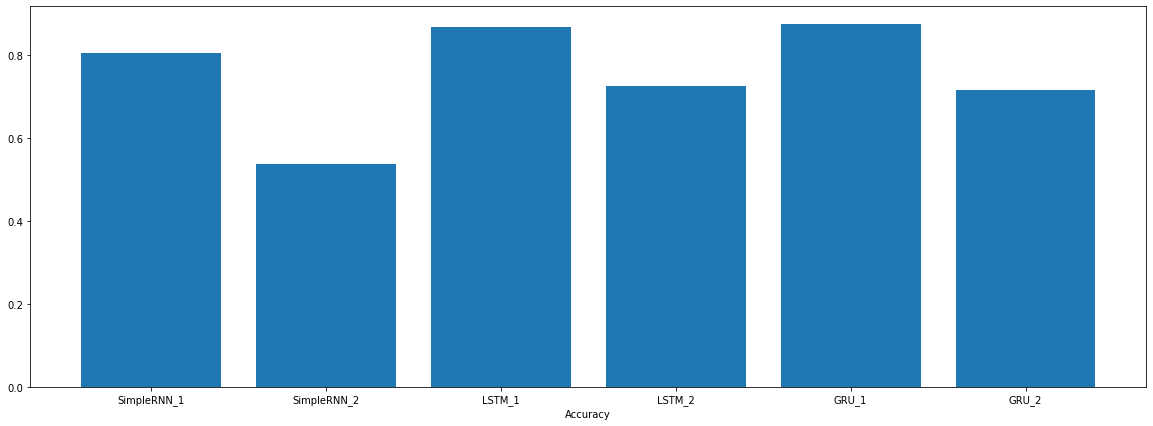

In [277]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xlabel('Accuracy')
keys = acc.keys()
values = acc.values()

acc
plt.bar(keys, values)

<BarContainer object of 6 artists>

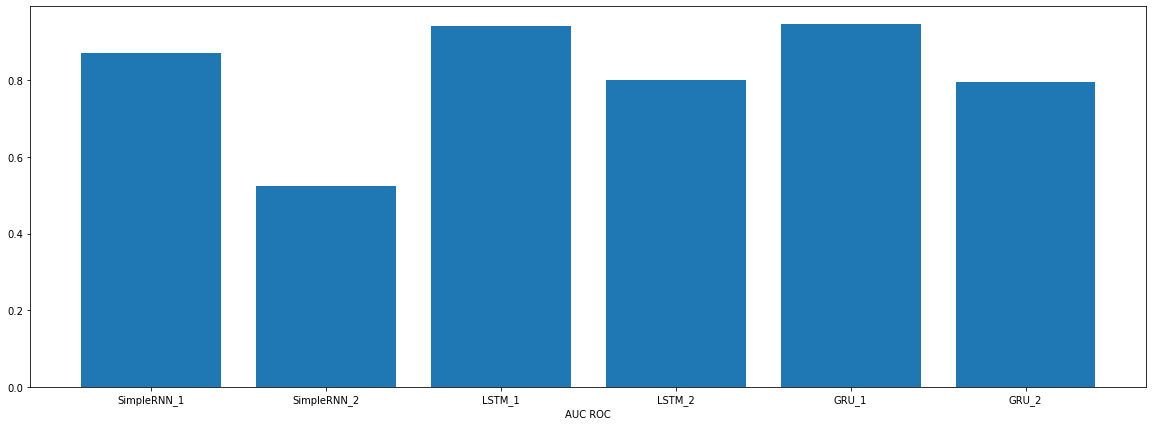

In [278]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xlabel('AUC ROC')
keys = auc_res.keys()
values = auc_res.values()

auc_res
plt.bar(keys, values)